# 【双归一化网络】评估训练后的编码器质量

* 基于原DINOfrom Py01shared_code import TerrainDataset, Proj_layer的代码：eval_knn.py更改而来
* 提取特征，做了可视化。最后的可视化结果与knn无关

## 20230513log

* 【整理】把数据集、投射层、DINO数据增强放到了共享文件里面（TerrainDataset, Proj_layer, DataAugmentationDINO）
- 【理解】理清楚了训练（NB03）和测试（NB05）中使用的数据增强，
    - 训练使用DINOAug返回10张图像的list和标签组成的元组（list(tensor1, tensor2……), index）
    - 测试使用简单的transform返回一个tensor和标签组成的元组（tensor, index）
* 【删除】删除了Xcit的代码（NB03中），因为并未使用它
* 【更改】TerrainDataset。**TerrainDataset中多做一步**，判断每次是增强了多个还是一个，多个的话返回list，一个直接返回tensor

## 20230528log

* 【描述】迁移到NB14，专为双归一化数据集使用（双结构与EEnT都可用）
* 【特性】加入EEnT支持
* 【使用】
    * 1 "--arch"参数：如BiNet_NO1、EEnT_tiny_NO1
    * 2 "--num_ele_slice"参数，确保与选择的预训练权重中的，切片数一致
    * 3 "--pretrained_weights"参数：保存的预训练权重路径
    * 4 "--data_path"参数，决定要进行测试数据，通常（默认）采用'./Data_geo/深度学习地形数据'，8000数据集进行测试。它包含train和test两个set
    * 【情况】如果是特征已经保存，可以加载上次的特征：
        * "--load_features"参数指定是否加载上次特征参数

In [1]:
from Py01shared_code import TerrainDataset, Proj_layer
from Py02ExtractFeature_shared import extract_features, extract_feature_pipeline
from Py04Model_load import get_args
from Py06BiNet import extract_feature_pipeline_Bi

In [2]:
# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import sys
import argparse

import torch
from torch import nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms as pth_transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits
import numpy as np
from PIL import Image
from einops import rearrange

In [3]:
dataset=datasets.ImageFolder

In [4]:
vit_em_dim = 192
conv_em_dim = 16 # 0 表示没有

In [5]:
args_self=[
# "--data_path","./Data_geo/Matching_test_high80/匹配test-high80",
# '--box_label_path',"./Data_geo/Matching_test_high80/【Label】匹配test-high80.csv",
# "--load_features","./dump_features", # 注释与否决定是否从文件加载特征
"--pretrained_weights", "./【checkpoint存档】/20230622【BiNet_Res_NO1】_01.pth",
# "--pretrained_weights", "./checkpoint.pth",
# "--arch", "BiNet_NO1",
'--arch', "BiNet_Res_NO1", # 一般可选BiNet_NO1、EEnT_tiny_NO1、EEnT_tiny_NO2, BiNet_Res_NO1, TBiNet_Res_NO2_bi
"--num_ele_slice", "100", # 专为EEnT中的高程嵌入使用的参数
]
args = get_args(args_self=args_self)

# 参数替换

* 如果从外部运行，且使用了其命名空间，可以通过检查某些变量是否存在来判断，是直接运行还是从外部运行

In [6]:
try:
    print("pre_model_path_outside = ", pre_model_path_outside)
#     net_name_outside
    print("num_ele_slice_outside = ", num_ele_slice_outside)
    print("arch_outside = ", arch_outside)
except NameError: # 外部定义变量不存在，使用本地，do noting
    print("外部变量不存在，使用【本地变量】")
#     var_exists = False
else: # 外部变量存在，使用外部：替换
    print("外部变量存在，使用【外部配置】")
    args.pretrained_weights = pre_model_path_outside
    args.arch = arch_outside
    args.num_ele_slice = num_ele_slice_outside
#     net_name = net_name_outside
#     var_exists = True

外部变量不存在，使用【本地变量】


# knn分类

In [6]:
@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=1000):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 10
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).to(train_features.device)
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5


# class ReturnIndexDataset(TerrainDataset):
#     def __getitem__(self, idx):
#         img, lab = super(ReturnIndexDataset, self).__getitem__(idx)
#         return img, idx

# main

In [7]:
if __name__ == '__main__':
#     parser = argparse.ArgumentParser('Evaluation with weighted k-NN on ImageNet')
#     parser.add_argument('--batch_size_per_gpu', default=128, type=int, help='Per-GPU batch-size')
#     parser.add_argument('--nb_knn', default=[10, 20, 100, 200], nargs='+', type=int,
#         help='Number of NN to use. 20 is usually working the best.')
#     parser.add_argument('--temperature', default=0.07, type=float,
#         help='Temperature used in the voting coefficient')
#     parser.add_argument('--pretrained_weights', default='./checkpoint.paaaaaaaaaaaaaaaaaaaaaaa【【【【【】】】】】th', type=str, help="Path to pretrained weights to evaluate.")
#     parser.add_argument('--use_cuda', default=True, type=utils.bool_flag,
#         help="Should we store the features on GPU? We recommend setting this to False if you encounter OOM")
#     parser.add_argument('--arch', default='vit_tiny', type=str, help='Architecture')
#     parser.add_argument('--patch_size', default=16, type=int, help='Patch resolution of the model.')
#     parser.add_argument("--checkpoint_key", default="teacher", type=str,
#         help='Key to use in the checkpoint (example: "teacher")')
#     parser.add_argument('--dump_features', default='./dump_features',
#         help='Path where to save computed features, empty for no saving')
#     parser.add_argument('--load_features', default=None, help="""If the features have
#         already been computed, where to find them.""")
#     parser.add_argument('--num_workers', default=10, type=int, help='Number of data loading workers per GPU.')
#     parser.add_argument("--dist_url", default="env://", type=str, help="""url used to set up
#         distributed training; see https://pytorch.org/docs/stable/distributed.html""")
#     parser.add_argument("--local_rank", default=0, type=int, help="Please ignore and do not set this argument.")
#     parser.add_argument('--data_path', default='./Data_geo/深度学习地形数据', type=str)
#     parser.add_argument('--num_ele_slice', default=100, type=int, help='num_ele_slice, 切分高度的层数')
    
    assert os.path.exists(args.pretrained_weights), "权重不存在，检查路径"
#     args = parser.parse_args(args=args_self)

#     utils.init_distributed_mode(args)
    try:
        utils.init_distributed_mode(args)
    except:
        print("已经启动，不再重复")
        pass
    print("git:\n  {}\n".format(utils.get_sha()))
    print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    if args.load_features:
        train_features = torch.load(os.path.join(args.load_features, "trainfeat.pth"))
        test_features = torch.load(os.path.join(args.load_features, "testfeat.pth"))
        train_labels = torch.load(os.path.join(args.load_features, "trainlabels.pth"))
        test_labels = torch.load(os.path.join(args.load_features, "testlabels.pth"))
    else:
        # need to extract features !
        train_features, test_features, train_labels, test_labels, data_train_ele_li, data_val_ele_li = extract_feature_pipeline_Bi(args)

    if utils.get_rank() == 0:
        if args.use_cuda:
            train_features = train_features.cuda()
            test_features = test_features.cuda()
            train_labels = train_labels.cuda()
            test_labels = test_labels.cuda()

        print("Features are ready!\nStart the k-NN classification.")
        train_labels_zero = torch.zeros(len(train_labels)).long().cuda()
        test_labels_zero = torch.zeros(len(test_labels)).long().cuda()
        for k in args.nb_knn:
            top1, top5 = knn_classifier(train_features, train_labels_zero,
                test_features, test_labels_zero, k, args.temperature)
            print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
    dist.barrier()

Will run the code on one GPU.
| distributed init (rank 0): env://


fatal: not a git repository (or any parent up to mount point /root)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


git:
  sha: N/A, status: clean, branch: N/A

arch: BiNet_Res_NO1
batch_size_per_gpu: 128
box_label_path: ./path_to【Label】.csv
checkpoint_key: teacher
data_path: ./Data_geo/深度学习地形数据
dist_url: env://
dump_features: ./dump_features
gpu: 0
load_features: None
local_rank: 0
nb_knn: [10, 20, 100, 200]
num_ele_slice: 100
num_workers: 10
patch_size: 16
pretrained_weights: ./【checkpoint存档】/20230622【BiNet_Res_NO1】_01.pth
rank: 0
temperature: 0.07
use_cuda: True
world_size: 1
获取数据集最大最小值……
数据集最大最小值为(-9655.287, 5201.252)
获取数据集分位数……
数据集最大最小值为(-9655.287, 5201.252)
获取数据集data_train高程分位数完成
获取数据集分位数……
数据集最大最小值为(-27.383964414214145, 47.99794099213954)
获取数据集data_val高程分位数完成
Data loaded with 8363 train and 49 val imgs.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./【checkpoint存档】/20230622【BiNet_Res_NO1】_01.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight',

In [8]:
y_train = train_labels.cpu()
x_train = train_features.cpu()
y_train_zero = torch.zeros(len(train_labels)).cpu()
data_train = torch.cat([x_train,y_train_zero.unsqueeze(1)], dim = 1)
print("训练数据集")
print(y_train.shape)
print(x_train.shape)
print(data_train.shape)

# print(train_features)

训练数据集
torch.Size([8363])
torch.Size([8363, 208])
torch.Size([8363, 209])


In [9]:
y_test = test_labels.cpu()
x_test = test_features.cpu()
y_test_zero = torch.zeros(len(test_labels)).cpu()
data_test = torch.cat([x_test,y_test_zero.unsqueeze(1)], dim = 1)
print("测试数据集")
print(y_test.shape)
print(x_test.shape)
print(data_test.shape)

# print(x_test)

测试数据集
torch.Size([49])
torch.Size([49, 208])
torch.Size([49, 209])


In [10]:
# !pip install sklearn

In [11]:
# 作图之前清除所有csv与tiff
li = os.listdir("./TSNE/")
li = ["./TSNE/" + item for item in li if item.endswith((".tiff", ".csv"))]
# 删除
for item_path in li:
    os.remove(item_path)

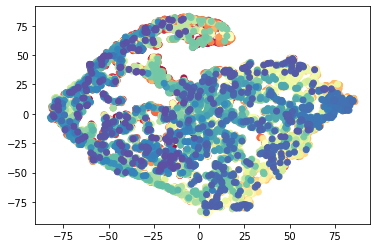

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn
tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=1000)
tsne.fit_transform(x_train, y =y_train)
x_2dim_train = tsne.embedding_
# print(x_2dim)
plt.scatter(x_2dim_train[:, 0], x_2dim_train[:, 1], c=data_train_ele_li, cmap=plt.cm.Spectral)
plt.savefig('./TSNE/data_train_big.tiff', dpi = 300)
plt.show()

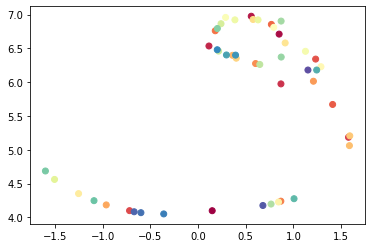

In [13]:
# tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=1000)
# tsne.fit_transform(x_test, y =y_test)
# x_2dim_test = tsne.embedding_
# # print(x_2dim)
# plt.scatter(x_2dim_test[:, 0], x_2dim_test[:, 1], c=data_val_ele_li, cmap=plt.cm.Spectral)
# plt.savefig('./TSNE/data_test.tiff', dpi = 300)
# # plt.savefig('./TSNE/data_test.svg')
# plt.show()
# np.savetxt('./TSNE/data_test.csv',x_2dim_test,fmt='%.2f',delimiter=',')

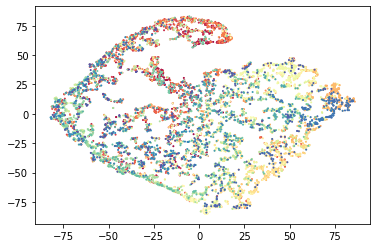

In [14]:
plt.scatter(x_2dim_train[:, 0], x_2dim_train[:, 1], s=1, c=data_train_ele_li, cmap=plt.cm.Spectral)
plt.savefig('./TSNE/data_train.tiff', dpi = 300)
# plt.savefig('TSNE/data_train.svg')
plt.show()
np.savetxt('./TSNE/data_train.csv',x_2dim_train,fmt='%.2f',delimiter=',')

融合前单ViT特征


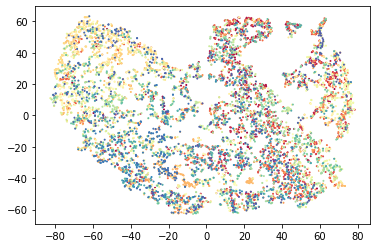

In [15]:
# 融合前单ViT特征
try:
    if vit_em_dim != 0: # 如果有拼接维度（双网络）
        tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=1000)
        tsne.fit_transform(x_train[:,0:vit_em_dim], y =y_train)
        x_2dim_train = tsne.embedding_
        print("融合前单ViT特征")
        plt.scatter(x_2dim_train[:, 0], x_2dim_train[:, 1], s=1, c=y_train, cmap=plt.cm.Spectral)
        plt.savefig('./TSNE/data_train_192ViTfea_Only.tiff', dpi = 300)
    #     plt.savefig('TSNE/data_train_192ViTfea_Only.svg')
        plt.show()
        np.savetxt('./TSNE/data_train_192ViTfea_Only.csv',x_2dim_train,fmt='%.2f',delimiter=',')
except:
    print("无法绘制单ViT特征，跳过")
    pass

融合前单Conv特征


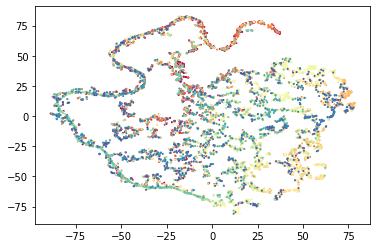

In [16]:
# 融合前Conv特征
try:
    if conv_em_dim != 0: # 如果有拼接维度（双网络）
        tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=1000)
        tsne.fit_transform(x_train[:, vit_em_dim:(vit_em_dim+conv_em_dim)], y =y_train)
        x_2dim_train = tsne.embedding_
        print("融合前单Conv特征")
        plt.scatter(x_2dim_train[:, 0], x_2dim_train[:, 1], s=1, c=y_train, cmap=plt.cm.Spectral)
        plt.savefig('./TSNE/data_train_convfea_Only.tiff', dpi = 300)
    #     plt.savefig('./TSNE/data_train_convfea_Only.svg')
        plt.show()
        np.savetxt('./TSNE/data_train_convfea_Only.csv',x_2dim_train,fmt='%.2f',delimiter=',')
except:
    print("无法绘制单Conv特征，跳过")
    pass